# Tutorial 8: CV preset

<img src="../../imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:100%;"/>

Official LightAutoML github repository is [here](https://github.com/sb-ai-lab/LightAutoML)


In this tutorial we will look how to apply LightAutoML to computer vision tasks. 

Basically, the corresponding modules are designed to solve problems where the image is more of an auxiliary value (complement the rest of the data from the table) than for solving full-fledged CV problems. In LightAutoML working with images goes essentially through tabular data, that is, not the images themselves are used, but the paths for them. They should be written in a separate column, which needs to specify the corresponding ```'path'``` role. The target variable and optionally other features are also specified in the table. To make predictions, numerical features are extracted from images, such as color histograms (RGB or HSV) and image embeddings based on EfficientNet (with the option to select a version and use [AdvProp weights](https://arxiv.org/abs/1911.09665)), and then standard machine learning models available in LightAutoML (as in conventional tabular presets) can be applied to them. By default, linear regression with L2 regularization and CatBoost are used. Linear regression is trained on image embeddings, CatBoost is trained on histogram features, and weighted blending is finally applied to their predictions.

As an example, let's consider the [Paddy Doctor competition](https://www.kaggle.com/competitions/paddy-disease-classification/data?select=train.csv) - the task of multi-class classification, determining the type of paddy leaf disease based on photographs and other numerical features. Data is a set of images and a table, each row of which corresponds to a specific image with a specification of the path to it.

## Importing libraries and preparing data


We will use the data from Kaggle. You can download the dataset [from this link](https://www.kaggle.com/competitions/paddy-disease-classification/data?select=train.csv) and import it in any convenient way. For example, we download the data using [kaggle API](https://www.kaggle.com/general/74235) and install some corresponding requirements. You can run next cell for loading data and installing packages in this way:

In [ ]:
##Kaggle functionality for loading data; Note that you have to use your kaggle API token (see the link above):
# !pip install opendatasets
# !pip install -q kaggle
# !pip install --upgrade --force-reinstall --no-deps kaggle
# !mkdir ~/.kaggle
# !ls ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c paddy-disease-classification

# #Unpack data:
# !mkdir paddy-disease
# !unzip paddy-disease-classification.zip -d paddy-disease

# #Install LightAutoML, Pandas and torch EfficientNet:
# !pip install -U lightautoml[cv] #[cv] is for installing CV tasks functionality




Then we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: `TabularCVAutoML` preset for AutoML model creation and Task class to setup what kind of ML problem we solve (binary/multiclass classification or regression)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.image_presets import TabularCVAutoML
from lightautoml.tasks import Task

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


/home/dvladimirvasilyev/LightAutoML/lightautoml/ml_algo/dl_model.py:41: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
/home/dvladimirvasilyev/LightAutoML/lightautoml/text/nn_model.py:22: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
/home/dvladimirvasilyev/LightAutoML/lightautoml/text/dl_transformers.py:25: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")



For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [3]:
np.random.seed(42)
torch.set_num_threads(2)


Let's check the data we have:

In [4]:
INPUT_DIR = './paddy-disease/'

In [5]:
train_data = pd.read_csv(INPUT_DIR + 'train.csv')
print(train_data.shape)
train_data.head()

(10407, 4)


,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [6]:
train_data['label'].value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

In [7]:
train_data['variety'].value_counts()

ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: variety, dtype: int64

In [8]:
train_data['age'].value_counts()

70    3077
60    1660
50    1066
75     866
65     774
55     563
72     552
45     505
67     415
68     253
80     225
57     213
47     112
77      42
73      38
66      36
62       5
82       5
Name: age, dtype: int64

In [9]:
submission = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
print(submission.shape)
submission.head()

(3469, 2)


,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN


Add a column with the full path to the images:

In [10]:
%%time

train_data['path'] = INPUT_DIR + 'train_images/' + train_data['label'] + '/' + train_data['image_id']
train_data.head()

CPU times: user 4.89 ms, sys: 485 µs, total: 5.37 ms
Wall time: 5.14 ms


,image_id,label,variety,age,path
0,100330.jpg,bacterial_leaf_blight,ADT45,45,./paddy-disease/train_images/bacterial_leaf_bl...
1,100365.jpg,bacterial_leaf_blight,ADT45,45,./paddy-disease/train_images/bacterial_leaf_bl...
2,100382.jpg,bacterial_leaf_blight,ADT45,45,./paddy-disease/train_images/bacterial_leaf_bl...
3,100632.jpg,bacterial_leaf_blight,ADT45,45,./paddy-disease/train_images/bacterial_leaf_bl...
4,101918.jpg,bacterial_leaf_blight,ADT45,45,./paddy-disease/train_images/bacterial_leaf_bl...


In [11]:
submission['path'] = INPUT_DIR + 'test_images/' + submission['image_id']
submission.head()

,image_id,label,path
0,200001.jpg,NaN,./paddy-disease/test_images/200001.jpg
1,200002.jpg,NaN,./paddy-disease/test_images/200002.jpg
2,200003.jpg,NaN,./paddy-disease/test_images/200003.jpg
3,200004.jpg,NaN,./paddy-disease/test_images/200004.jpg
4,200005.jpg,NaN,./paddy-disease/test_images/200005.jpg


Let's expand the training data with augmentations: random rotations and flips:

In [ ]:
os.mkdir('./paddy-disease/modified_train')

In [12]:
from PIL import Image
from tqdm.notebook import tqdm
new_imgs = []

for i, p in tqdm(enumerate(train_data['path'].values)):
    if i % 1000 == 0: 
        print(i)
        
    img = Image.open(p)

    for it in range(10):
        new_img = img.rotate(np.random.rand() * 60 - 30, resample=3)
  
        if np.random.rand() > 0.5:
            new_img = new_img.transpose(Image.FLIP_LEFT_RIGHT)
        
        new_img_name = './paddy-disease/modified_train/' + p.split('/')[-1][:-4] + '_' + str(it) + '.jpg'
        new_img.save(new_img_name)
        new_imgs.append([new_img_name, p.split('/')[-2], p.split('/')[-1]])

0it [00:00, ?it/s]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [13]:
train_data = pd.concat([train_data, pd.DataFrame(new_imgs, columns = ['path', 'label', 'image_id'])]).reset_index(drop = True)
train_data

,image_id,label,variety,age,path
0,100330.jpg,bacterial_leaf_blight,ADT45,45.0,./paddy-disease/train_images/bacterial_leaf_bl...
1,100365.jpg,bacterial_leaf_blight,ADT45,45.0,./paddy-disease/train_images/bacterial_leaf_bl...
2,100382.jpg,bacterial_leaf_blight,ADT45,45.0,./paddy-disease/train_images/bacterial_leaf_bl...
3,100632.jpg,bacterial_leaf_blight,ADT45,45.0,./paddy-disease/train_images/bacterial_leaf_bl...
4,101918.jpg,bacterial_leaf_blight,ADT45,45.0,./paddy-disease/train_images/bacterial_leaf_bl...
...,...,...,...,...,...
114472,110381.jpg,tungro,NaN,NaN,./paddy-disease/modified_train/110381_5.jpg
114473,110381.jpg,tungro,NaN,NaN,./paddy-disease/modified_train/110381_6.jpg
114474,110381.jpg,tungro,NaN,NaN,./paddy-disease/modified_train/110381_7.jpg
114475,110381.jpg,tungro,NaN,NaN,./paddy-disease/modified_train/110381_8.jpg


Let's do the same for the test dataset:

In [22]:
os.mkdir('./paddy-disease/modified_test')

In [14]:
new_imgs = []

for i, p in tqdm(enumerate(submission['path'].values)):
    if i % 1000 == 0: 
        print(i)
      
    img = Image.open(p)

    for it in range(5):
        new_img = img.rotate(np.random.rand() * 60 - 30, resample=3)
        if np.random.rand() > 0.5:
            new_img = new_img.transpose(Image.FLIP_LEFT_RIGHT)
        
        new_img_name = './paddy-disease/modified_test/' + p.split('/')[-1][:-4] + '_' + str(it) + '.jpg'
        new_img.save(new_img_name)
        new_imgs.append([new_img_name, p.split('/')[-1]])

0it [00:00, ?it/s]

0
1000
2000
3000


In [15]:
submission = pd.concat([submission, pd.DataFrame(new_imgs, columns = ['path', 'image_id'])]).reset_index(drop = True)
submission

,image_id,label,path
0,200001.jpg,NaN,./paddy-disease/test_images/200001.jpg
1,200002.jpg,NaN,./paddy-disease/test_images/200002.jpg
2,200003.jpg,NaN,./paddy-disease/test_images/200003.jpg
3,200004.jpg,NaN,./paddy-disease/test_images/200004.jpg
4,200005.jpg,NaN,./paddy-disease/test_images/200005.jpg
...,...,...,...
20809,203469.jpg,NaN,./paddy-disease/modified_test/203469_0.jpg
20810,203469.jpg,NaN,./paddy-disease/modified_test/203469_1.jpg
20811,203469.jpg,NaN,./paddy-disease/modified_test/203469_2.jpg
20812,203469.jpg,NaN,./paddy-disease/modified_test/203469_3.jpg


## Task definition

### Task type

On the cell below we create ```Task``` object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation). In general, it can be any type of tasks available in LightAutoML (binary and multi-class classification, one-dimensional and multi-dimensional regression, multi-label classification), but in this case we have a multi-class classification task:

In [16]:
task = Task('multiclass')

Default metric and loss in multi-class classification is cross-entropy.

### Feature roles setup

Next we need to setup columns roles. It is necessary to specify the role of the target variable (```'target'```), as well as the role of the path to the images (```'path'```) in the case of using ```TabularCVAutoML```. We will also group the images (the original ones and their augmentations) and apply group k-fold cross-validation, specifying the column with ids as the ```'group'``` role:

In [17]:
roles = {
    'target': 'label',
    'path': ['path'],
    'drop': ['variety', 'age'],
    'group': 'image_id'
}

Then we initialize ```TabularCVAutoML```. It is possible to specify many parameters (reader parameters, time and memory limits etc), including the EfficientNet parameters for getting embeddings: version (```B0``` by default), device, batch size (128 by default), path for weights, [AdvProp weights](https://arxiv.org/abs/1911.09665) using (for better use of the shape in images, ```True``` by default) etc. Note that the ```Utilized``` version of ```TabularCVAutoML``` for more flexible use of time resources is not yet available.

In [18]:
automl = TabularCVAutoML(task = task,
                         timeout=5 * 3600,
                        cpu_limit = 2,
                        reader_params = {'cv': 5, 'random_state': 42})

## AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [19]:
%%time 

oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 3)

[14:04:32] Stdout logging level is INFO3.
[14:04:32] Task: multiclass

[14:04:32] Start automl preset with listed constraints:
[14:04:32] - time: 18000.00 seconds
[14:04:32] - CPU: 2 cores
[14:04:32] - memory: 16 GB

[14:04:32] Train data shape: (114477, 5)

[14:04:32] Layer 1 train process start. Time left 17999.83 secs


100%|██████████| 895/895 [07:29<00:00,  1.99it/s]


[14:12:09] Feature path transformed
[14:12:16] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[14:12:17] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[14:12:26] Linear model: C = 1e-05 score = -0.9995305866945853
[14:12:32] Linear model: C = 5e-05 score = -0.6879959560713191
[14:12:38] Linear model: C = 0.0001 score = -0.5802952177399445
[14:12:45] Linear model: C = 0.0005 score = -0.3907926611544111
[14:12:51] Linear model: C = 0.001 score = -0.33425017155675657
[14:13:00] Linear model: C = 0.005 score = -0.2559518217619532
[14:13:07] Linear model: C = 0.01 score = -0.24141776919439237
[14:13:15] Linear model: C = 0.05 score = -0.2431661172897411
[14:13:23] Linear model: C = 0.1 score = -0.25925367786528475
[14:13:24] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[14:13:32] Linear model: C = 1e-05 score = -0.9872444001968863
[14:13:39] Linear model: C = 5e-05 score = -0.6682540100549987
[14:13:45] Linear model: C = 0.0001 score = -0.5574

/home/dvladimirvasilyev/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


[14:23:59] Blending: iteration 0: score = -0.18573794844833624, weights = [0.63928086 0.36071914]
[14:23:59] Blending: iteration 1: score = -0.18573794844833624, weights = [0.63928086 0.36071914]
[14:23:59] Blending: no score update. Terminated

[14:23:59] Automl preset training completed in 1167.35 seconds

[14:23:59] Model description:
Final prediction for new objects (level 0) = 
	 0.63928 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.36072 * (5 averaged models Lvl_0_Pipe_1_Mod_0_CatBoost) 

CPU times: user 18min 40s, sys: 3min 1s, total: 21min 42s
Wall time: 19min 27s


Сonsider out-of-fold predictions on train data. In case of classification, ```LightAutoML``` returns class probabilities as an output.

In [21]:
preds = train_data[['image_id', 'label']]
preds

,image_id,label
0,100330.jpg,bacterial_leaf_blight
1,100365.jpg,bacterial_leaf_blight
2,100382.jpg,bacterial_leaf_blight
3,100632.jpg,bacterial_leaf_blight
4,101918.jpg,bacterial_leaf_blight
...,...,...
114472,110381.jpg,tungro
114473,110381.jpg,tungro
114474,110381.jpg,tungro
114475,110381.jpg,tungro


In [22]:
for i in range(10):
    preds['pred_' + str(i)] = oof_pred.data[:,i]
    
preds

/tmp/ipykernel_12895/1432655611.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['pred_' + str(i)] = oof_pred.data[:,i]
/tmp/ipykernel_12895/1432655611.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['pred_' + str(i)] = oof_pred.data[:,i]


,image_id,label,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
0,100330.jpg,bacterial_leaf_blight,0.023245,0.315283,0.470886,0.002528,0.021895,0.007454,0.001554,0.157142,8.914904e-06,4.559626e-06
1,100365.jpg,bacterial_leaf_blight,0.003717,0.011035,0.028317,0.000110,0.003178,0.000015,0.000131,0.953496,1.555987e-07,5.692390e-07
2,100382.jpg,bacterial_leaf_blight,0.025734,0.095088,0.208473,0.000879,0.007030,0.003382,0.000142,0.659271,3.872871e-07,2.898941e-07
3,100632.jpg,bacterial_leaf_blight,0.002876,0.542942,0.027466,0.000317,0.036005,0.000398,0.000082,0.389901,3.837710e-06,9.339438e-06
4,101918.jpg,bacterial_leaf_blight,0.009988,0.033572,0.017635,0.000032,0.008310,0.000136,0.000041,0.930286,1.554736e-07,1.530466e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
114472,110381.jpg,tungro,0.001716,0.109143,0.020722,0.001495,0.845324,0.000177,0.021384,0.000027,6.304998e-06,6.075803e-06
114473,110381.jpg,tungro,0.022644,0.137650,0.026389,0.004165,0.788036,0.001093,0.019688,0.000259,3.142513e-05,4.477663e-05
114474,110381.jpg,tungro,0.016897,0.072329,0.010469,0.005554,0.789777,0.001240,0.103631,0.000060,1.301366e-05,2.972130e-05
114475,110381.jpg,tungro,0.008637,0.114299,0.082281,0.003465,0.560001,0.000741,0.230260,0.000112,1.909918e-04,1.351225e-05


We will average forecasts for images by their augmentations:

In [23]:
preds = preds.groupby(['image_id', 'label']).mean().reset_index()
preds

,image_id,label,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
0,100001.jpg,brown_spot,0.001334,0.000791,0.002372,5.432664e-03,0.005328,0.978495,0.002519,0.003511,7.897679e-05,1.378119e-04
1,100002.jpg,normal,0.978428,0.011744,0.001621,3.187062e-03,0.002579,0.000282,0.000156,0.001969,3.391063e-05,1.971700e-07
2,100003.jpg,hispa,0.004639,0.002192,0.992883,1.573081e-07,0.000026,0.000037,0.000005,0.000218,1.920397e-07,1.528186e-07
3,100004.jpg,blast,0.000259,0.982406,0.004401,7.787708e-03,0.002372,0.002163,0.000173,0.000115,3.223106e-04,4.848040e-07
4,100005.jpg,hispa,0.010951,0.047475,0.829855,1.200308e-05,0.091933,0.000418,0.018967,0.000370,1.118553e-05,8.759866e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
10402,110403.jpg,tungro,0.001664,0.002167,0.007366,4.507852e-03,0.981122,0.000052,0.001666,0.001455,1.527430e-07,3.928369e-07
10403,110404.jpg,normal,0.932484,0.002359,0.049850,1.244102e-05,0.011696,0.000593,0.002646,0.000304,4.828784e-05,7.773816e-06
10404,110405.jpg,dead_heart,0.000192,0.000044,0.000152,9.994839e-01,0.000001,0.000025,0.000058,0.000003,1.957294e-06,3.789358e-05
10405,110406.jpg,blast,0.000226,0.977683,0.000268,9.254745e-03,0.004962,0.000595,0.004523,0.001717,5.624577e-04,2.080105e-04


Assign classes by maximum class probability:

In [24]:
OOFs = np.argmax(preds[['pred_' + str(i) for i in range(10)]].values, axis = 1)
OOFs

array([5, 0, 2, ..., 3, 1, 5])

Let's see classification accuracy on train:

In [25]:
accuracy = (OOFs == preds['label'].map(automl.reader.class_mapping)).mean()
print(f'Out-of-fold accuracy: {accuracy}')

Out-of-fold accuracy: 0.9686749303353512


Also to estimate the quality of classification, we can use the confusion matrix:

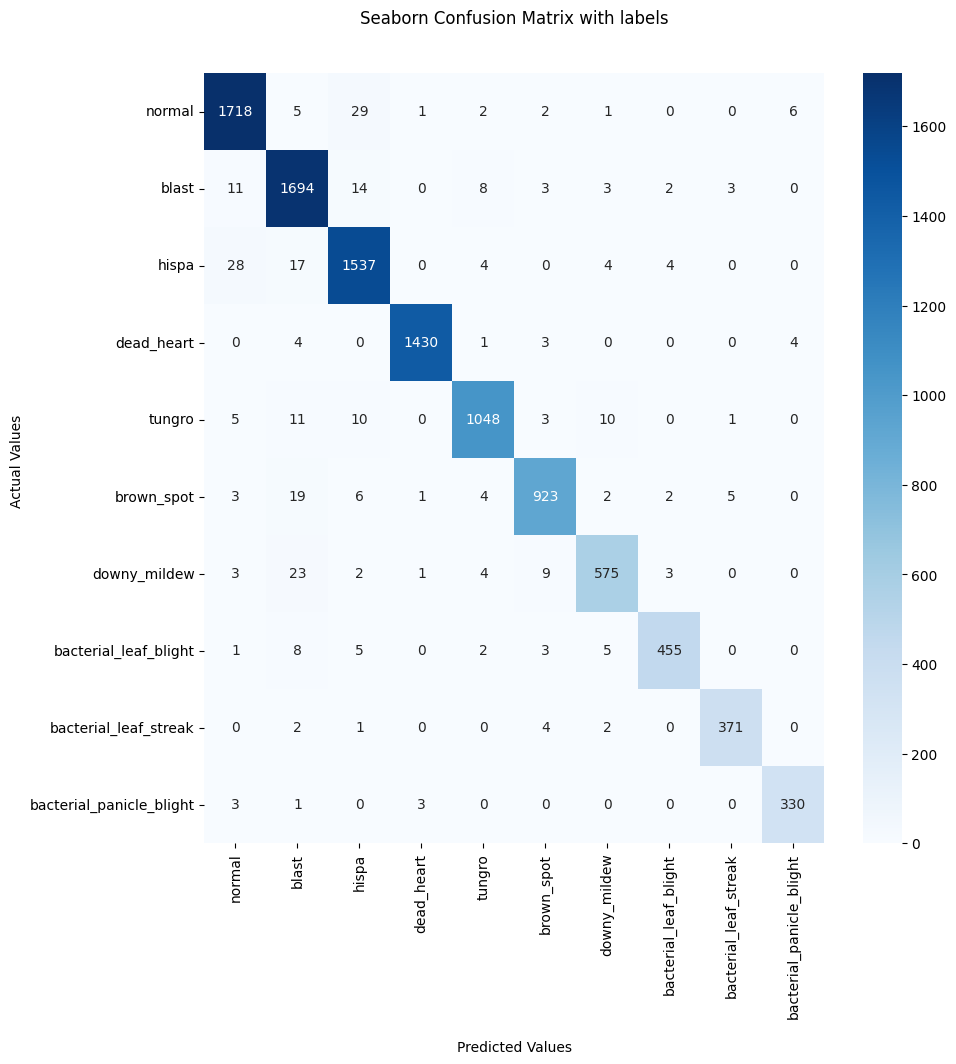

In [26]:
cf_matrix = confusion_matrix(preds['label'].map(automl.reader.class_mapping), 
                             OOFs)

plt.figure(figsize = (10, 10))

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt = 'd')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

inverse_class_mapping = {y: x for x,y in automl.reader.class_mapping.items()}
labels = [inverse_class_mapping[i] for i in range(len(inverse_class_mapping))]
ax.xaxis.set_ticklabels(labels, rotation = 90)
ax.yaxis.set_ticklabels(labels, rotation = 0)

plt.show()

## Predict for test dataset


Now we are also ready to predict for our test competition dataset and submission file creation:

In [27]:
%%time

te_pred = automl.predict(submission)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

100%|██████████| 163/163 [01:28<00:00,  1.84it/s]


[14:28:22] Feature path transformed
Prediction for te_data:
array([[1.57098308e-01, 2.81519257e-03, 5.96348643e-01, ...,
        1.08084995e-02, 1.95845146e-07, 1.42198633e-05],
       [9.83384371e-01, 6.52049668e-04, 1.45791359e-02, ...,
        1.12365209e-03, 9.75986836e-07, 1.95965598e-07],
       [1.68020770e-01, 3.79674375e-01, 1.86414778e-01, ...,
        1.67078048e-03, 1.21877249e-03, 3.75247910e-03],
       ...,
       [1.05072348e-03, 1.24680300e-05, 5.70231769e-03, ...,
        4.37476301e-05, 1.52421890e-07, 1.81421214e-07],
       [6.52685121e-04, 4.47798493e-06, 5.04824053e-03, ...,
        2.13344283e-05, 1.52417726e-07, 1.62638599e-07],
       [1.57185504e-03, 1.01540554e-05, 2.53849756e-02, ...,
        1.17763964e-04, 1.52426963e-07, 1.77946404e-07]], dtype=float32)
Shape = (20814, 10)
CPU times: user 55.8 s, sys: 21.6 s, total: 1min 17s
Wall time: 2min 19s


In [28]:
sub = submission[['image_id']]
for i in range(10):
    sub['pred_' + str(i)] = te_pred.data[:,i]
    
sub

/tmp/ipykernel_12895/1185757098.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['pred_' + str(i)] = te_pred.data[:,i]


,image_id,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
0,200001.jpg,0.157098,0.002815,0.596349,0.020590,1.148577e-01,0.095614,0.001854,0.010808,1.958451e-07,1.421986e-05
1,200002.jpg,0.983384,0.000652,0.014579,0.000139,6.825896e-05,0.000044,0.000008,0.001124,9.759868e-07,1.959656e-07
2,200003.jpg,0.168021,0.379674,0.186415,0.000225,1.850213e-03,0.036919,0.220253,0.001671,1.218772e-03,3.752479e-03
3,200004.jpg,0.000013,0.990730,0.008530,0.000097,1.116415e-04,0.000215,0.000111,0.000037,1.548404e-04,1.946677e-07
4,200005.jpg,0.000340,0.999536,0.000031,0.000002,6.857538e-07,0.000003,0.000007,0.000029,5.404088e-07,4.985940e-05
...,...,...,...,...,...,...,...,...,...,...,...
20809,203469.jpg,0.003061,0.000017,0.041731,0.943745,1.648944e-04,0.010877,0.000146,0.000258,1.524480e-07,2.509265e-07
20810,203469.jpg,0.000430,0.000003,0.002508,0.993409,2.613632e-05,0.003580,0.000007,0.000036,1.524176e-07,1.595918e-07
20811,203469.jpg,0.001051,0.000012,0.005702,0.989972,5.734707e-05,0.003144,0.000018,0.000044,1.524219e-07,1.814212e-07
20812,203469.jpg,0.000653,0.000004,0.005048,0.990724,3.223727e-05,0.003505,0.000012,0.000021,1.524177e-07,1.626386e-07


In [29]:
sub = sub.groupby(['image_id']).mean().reset_index()
sub

,image_id,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
0,200001.jpg,0.127650,0.001409,0.599914,0.017568,0.136898,0.106915,0.001796,0.007829,8.801418e-06,1.216593e-05
1,200002.jpg,0.937035,0.000638,0.060420,0.000098,0.000105,0.000096,0.000016,0.001586,6.087082e-06,2.249314e-07
2,200003.jpg,0.120163,0.523312,0.106169,0.000473,0.000748,0.042688,0.201373,0.002807,1.389023e-03,8.788786e-04
3,200004.jpg,0.000020,0.888623,0.006415,0.001150,0.000430,0.004390,0.000616,0.001799,9.654120e-02,1.466518e-05
4,200005.jpg,0.000680,0.998898,0.000085,0.000009,0.000001,0.000002,0.000021,0.000172,1.743805e-06,1.304403e-04
...,...,...,...,...,...,...,...,...,...,...,...
3464,203465.jpg,0.000224,0.002143,0.001514,0.990281,0.002657,0.000401,0.001074,0.000134,1.530934e-03,4.091801e-05
3465,203466.jpg,0.250769,0.007148,0.741840,0.000002,0.000022,0.000013,0.000076,0.000129,2.629060e-07,2.120279e-07
3466,203467.jpg,0.960745,0.004105,0.001135,0.000646,0.016724,0.008584,0.000062,0.007749,2.438365e-04,6.326832e-06
3467,203468.jpg,0.003675,0.001097,0.038018,0.000038,0.000483,0.000310,0.000223,0.000208,9.551883e-01,7.596347e-04


In [30]:
TEs = pd.Series(np.argmax(sub[['pred_' + str(i) for i in range(10)]].values, axis = 1)).map(inverse_class_mapping)
TEs

0                       hispa
1                      normal
2                       blast
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Length: 3469, dtype: object

In [31]:
sub['label'] = TEs
sub[['image_id', 'label']].to_csv('LightAutoML_TabularCVAutoML_with_aug.csv', index = False)
sub[['image_id', 'label']]

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,hispa
3466,203467.jpg,normal
3467,203468.jpg,bacterial_leaf_streak


Our submission has 0.95770 accuracy on [public](https://www.kaggle.com/competitions/paddy-disease-classification/leaderboard?tab=public#) and 0.95276 accuracy on [private](https://www.kaggle.com/competitions/paddy-disease-classification/leaderboard?) leaderboard ([Alexander Ryzhkov](https://www.kaggle.com/alexryzhkov) account).


## Additional materials

- [Official LightAutoML github repo](https://github.com/AILab-MLTools/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)
- [LightAutoML tutorials](https://github.com/AILab-MLTools/LightAutoML/tree/master/examples/tutorials)
- LightAutoML course:
    - [Part 1 - general overview](https://ods.ai/tracks/automl-course-part1) 
    - [Part 2 - LightAutoML specific applications](https://ods.ai/tracks/automl-course-part2)
    - [Part 3 - LightAutoML customization](https://ods.ai/tracks/automl-course-part3)
- [OpenDataScience AutoML benchmark leaderboard](https://ods.ai/competitions/automl-benchmark/leaderboard)